## Neural Network

This jupyter notebook implements the neural network model using convolutional layers

In [245]:
#Import libraries
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch 
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
import os
from sklearn.metrics import recall_score, accuracy_score, f1_score
import numpy as np
from XRayDataset import XRayDataset
from dataloader import train_path, test_path, val_path
import matplotlib.pylab as plt
import copy
%matplotlib inline

In [246]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.LeNet = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Sequential(
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Flatten(),
            nn.Linear(16 * 61 * 61, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2)
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out


In [247]:
model = CustomNeuralNetwork()

In [248]:
#Dataloader code from Checkpoint #1
resize = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.Resize((int(256), int(256))), # Resize the image to match median ratio using median length, we can try later with smaller length 
            T.ToTensor()
        ])
 
transforms = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.RandomAdjustSharpness(sharpness_factor=10),
            T.ColorJitter(brightness=.5, hue=.3),
            T.Resize((int(256), int(256))),
            # Resize the image to match median ratio using median length 
            T.ToTensor()
        ])
training_data = XRayDataset(train_path, transforms)
val_data = XRayDataset(val_path, resize)
test_data = XRayDataset(test_path, resize)


# article on batch sizes 
#https://medium.com/data-science-365/determining-the-right-batch-size-for-a-neural-network-to-get-better-and-faster-results-7a8662830f15

batch_s = 8

train_dataloader = DataLoader(training_data, batch_size=batch_s, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_s, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_s, shuffle=True)


In [249]:
# 3: Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 15

In [250]:
# 4: Train and validate the network
train_losses = []
train_accuracies = []
train_recalls = []
for _ in range(EPOCHS):
    # TRAIN
    model.train()  # Make sure gradient tracking is on, and do a pass over the data
    running_loss = 0.0
    y_true = np.array([])
    y_predict = np.array([])
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        loss = criterion(outputs, labels_tensor)  # calculate loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights
        running_loss += loss.item()
        y_true = np.concatenate((y_true, labels_tensor.numpy()))
        y_pred_batch = np.argmax(outputs.detach().numpy(), axis=1)
        y_predict = np.concatenate((y_predict, y_pred_batch))
    
    epoch_accuracy = (y_predict == y_true).mean()
    epoch_recall = recall_score(y_true, y_predict, average='binary')
    train_losses.append(running_loss)
    train_accuracies.append(epoch_accuracy)
    train_recalls.append(epoch_recall)

In [259]:
# y_predict, y_true, train_losses, train_accuracies, train_recalls = train(model)
print("y_predict", y_predict)
print("y_true", y_true)
print(train_losses)
print(train_accuracies)
print(train_recalls)

y_predict [0. 0. 0. ... 0. 0. 0.]
y_true [0. 0. 0. ... 0. 0. 0.]
[158.35907375189709, 106.81069568824023, 83.6777424919419, 62.89484272041591, 53.73242619610028, 40.87496738430491, 34.25286839243381, 25.394783228109077, 22.365321830934818, 11.825338398307963, 18.929784512146057, 10.28202505946706, 11.981147842292167, 11.545603251239001, 6.918615312110557]
[0.9010736196319018, 0.9380751533742331, 0.9520705521472392, 0.964340490797546, 0.9670245398773006, 0.9741180981595092, 0.9810199386503068, 0.9854294478527608, 0.9873466257668712, 0.9930981595092024, 0.9892638036809815, 0.9950153374233128, 0.9929064417177914, 0.9938650306748467, 0.9959739263803681]
[0.7531692766592095, 0.8590604026845637, 0.9000745712155108, 0.9276659209545116, 0.935868754660701, 0.9492915734526473, 0.9679343773303505, 0.9739000745712155, 0.9739000745712155, 0.9880686055182699, 0.9813571961222968, 0.9910514541387024, 0.9873228933631618, 0.9880686055182699, 0.9903057419835943]


In [263]:
# 4: Train and validate the network
val_losses = []
val_accuracies = []
val_recalls = []
for _ in range(EPOCHS):
    # VAL
    model.eval()  # # we don't want to keep track of the gradients in the validation part
    val_running_loss = 0.0
    y_true_val = np.array([])
    y_predict_val = np.array([])
    for i, data in enumerate(val_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        loss = criterion(outputs, labels_tensor)  # calculate loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights
        val_running_loss += loss.item()
        y_true_val = np.concatenate((y_true_val, labels_tensor.numpy()))
        y_predict_val = np.concatenate((y_predict_val, outputs.argmax(dim=1).numpy()))

    val_epoch_accuracy = (y_predict_val == y_true_val).mean()
    val_epoch_recall = recall_score(y_true_val, y_predict_val, average='binary')
    val_losses.append(val_running_loss)
    val_accuracies.append(val_epoch_accuracy)
    val_recalls.append(val_epoch_recall)

In [264]:
print(val_accuracies)
print(val_losses)
print(val_recalls)

unique, counts = np.unique(y_predict_val, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.007886806270107627, 0.004189531318843365, 0.002303596935234964, 0.001748657668940723, 0.0014321973139885813, 0.0012194283481221646, 0.0010613700142130256, 0.0009541491454001516, 0.0008478352683596313, 0.0007466681163350586, 0.000701395227224566, 0.0006472112145274878, 0.0005973345250822604, 0.0005627408027066849, 0.0005260951875243336]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.0: 8
1.0: 8


In [262]:
#5. Test model
test_losses = []
test_accuracies = []
test_recalls = []
with torch.no_grad():
    for _ in range(EPOCHS):
        # TEST
        model.train()  # Make sure gradient tracking is on, and do a pass over the data
        test_running_loss = 0.0
        y_true_test = np.array([])
        y_predict_test = np.array([])
        for i, data in enumerate(test_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward pass
            # print("OUTPUTS: ", outputs)
            label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
            labels_tensor = torch.tensor([label_dict[label] for label in labels])
            loss = criterion(outputs, labels_tensor)  # calculate loss
            optimizer.step()  # update weights
            test_running_loss += loss.item()
            y_true_test = np.concatenate((y_true_test, labels_tensor.numpy()))
            y_predict_test = np.concatenate((y_predict_test, outputs.argmax(dim=1).numpy()))

    test_epoch_accuracy = (y_predict_test == y_true_test).mean()
    test_epoch_recall = recall_score(y_true_test, y_predict_test, average='binary')
    test_losses.append(test_running_loss)
    test_accuracies.append(test_epoch_accuracy)
    test_recalls.append(test_epoch_recall)

In [255]:
print("accuracy", test_accuracies)
print("loss", test_losses)
print("recall", test_recalls)

unique, counts = np.unique(y_predict_test, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")


accuracy [0.8221153846153846]
loss [68.48328257766298]
recall [0.6837606837606838]
0.0: 427
1.0: 197


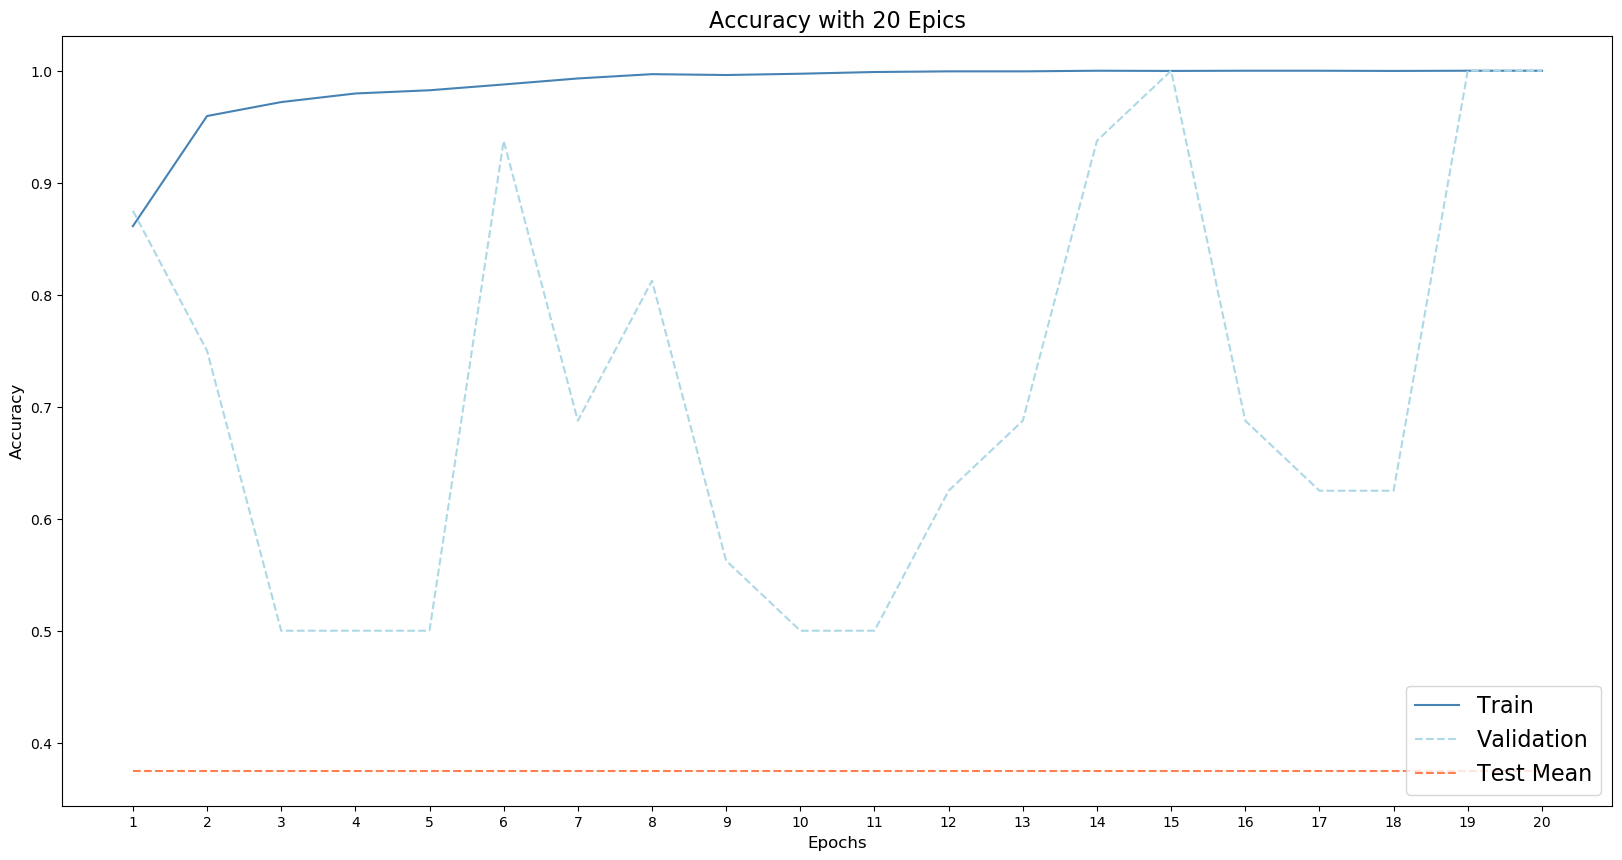

In [256]:
train_accuracies_20 = [0.8611963190184049, 0.95954754601227, 0.9720092024539877, 0.9796779141104295, 0.9825536809815951, 0.9877300613496932, 0.9930981595092024, 0.9969325153374233, 0.9961656441717791, 0.9973159509202454, 0.9988496932515337, 0.9994248466257669, 0.9994248466257669, 1.0, 0.999808282208589, 1.0, 1.0, 0.999808282208589, 1.0, 1.0]
val_accuracies_20 = [0.875, 0.75, 0.5, 0.5, 0.5, 0.9375, 0.6875, 0.8125, 0.5625, 0.5, 0.5, 0.625, 0.6875, 0.9375, 1.0, 0.6875, 0.625, 0.625, 1.0, 1.0]
test_accuracies_20 =  [0.375] * 20 
epochs_20 = [i for i in range(1,20+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs_20, train_accuracies_20, color="steelblue", label= 'Train')
ax.plot(epochs_20, val_accuracies_20, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs_20, test_accuracies_20, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs_20)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy with 20 Epics", fontsize=16)
plt.show()

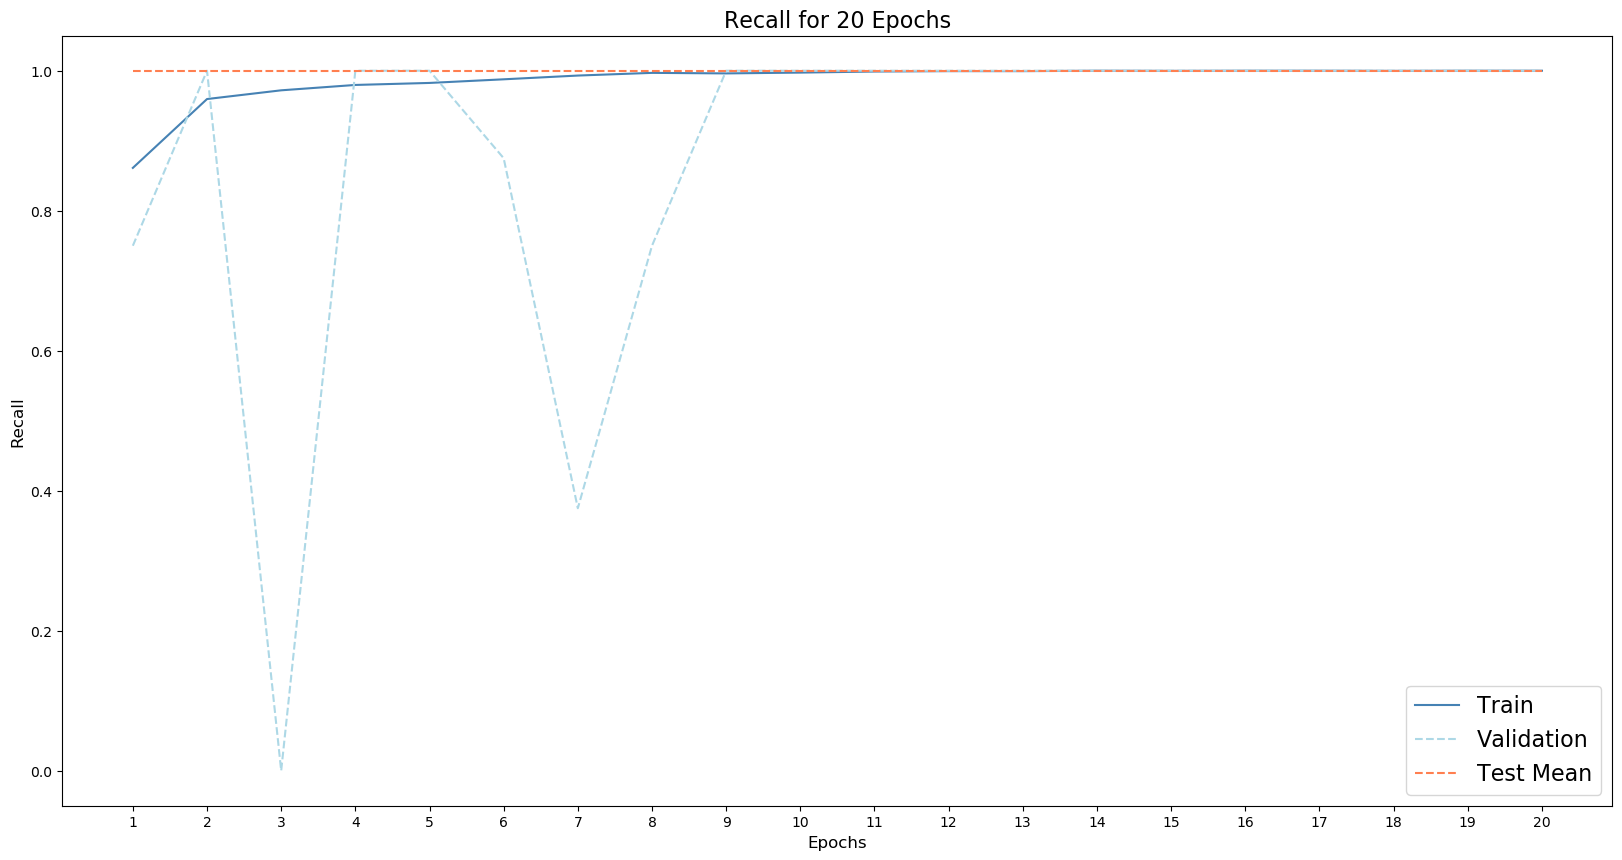

In [257]:
train_recall_20 = [0.8611963190184049, 0.95954754601227, 0.9720092024539877, 0.9796779141104295, 0.9825536809815951, 0.9877300613496932, 0.9930981595092024, 0.9969325153374233, 0.9961656441717791, 0.9973159509202454, 0.9988496932515337, 0.9994248466257669, 0.9994248466257669, 1.0, 0.999808282208589, 1.0, 1.0, 0.999808282208589, 1.0, 1.0]
val_recall_20 = [0.75, 1.0, 0.0, 1.0, 1.0, 0.875, 0.375, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
test_recall_20 = [1.0] * 20
epochs = [i for i in range(1,20+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_recall_20, color="steelblue", label= 'Train')
ax.plot(epochs, val_recall_20, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_recall_20, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Recall", fontsize=12)
ax.set_title("Recall for 20 Epochs", fontsize=16)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (5,) and (15,)

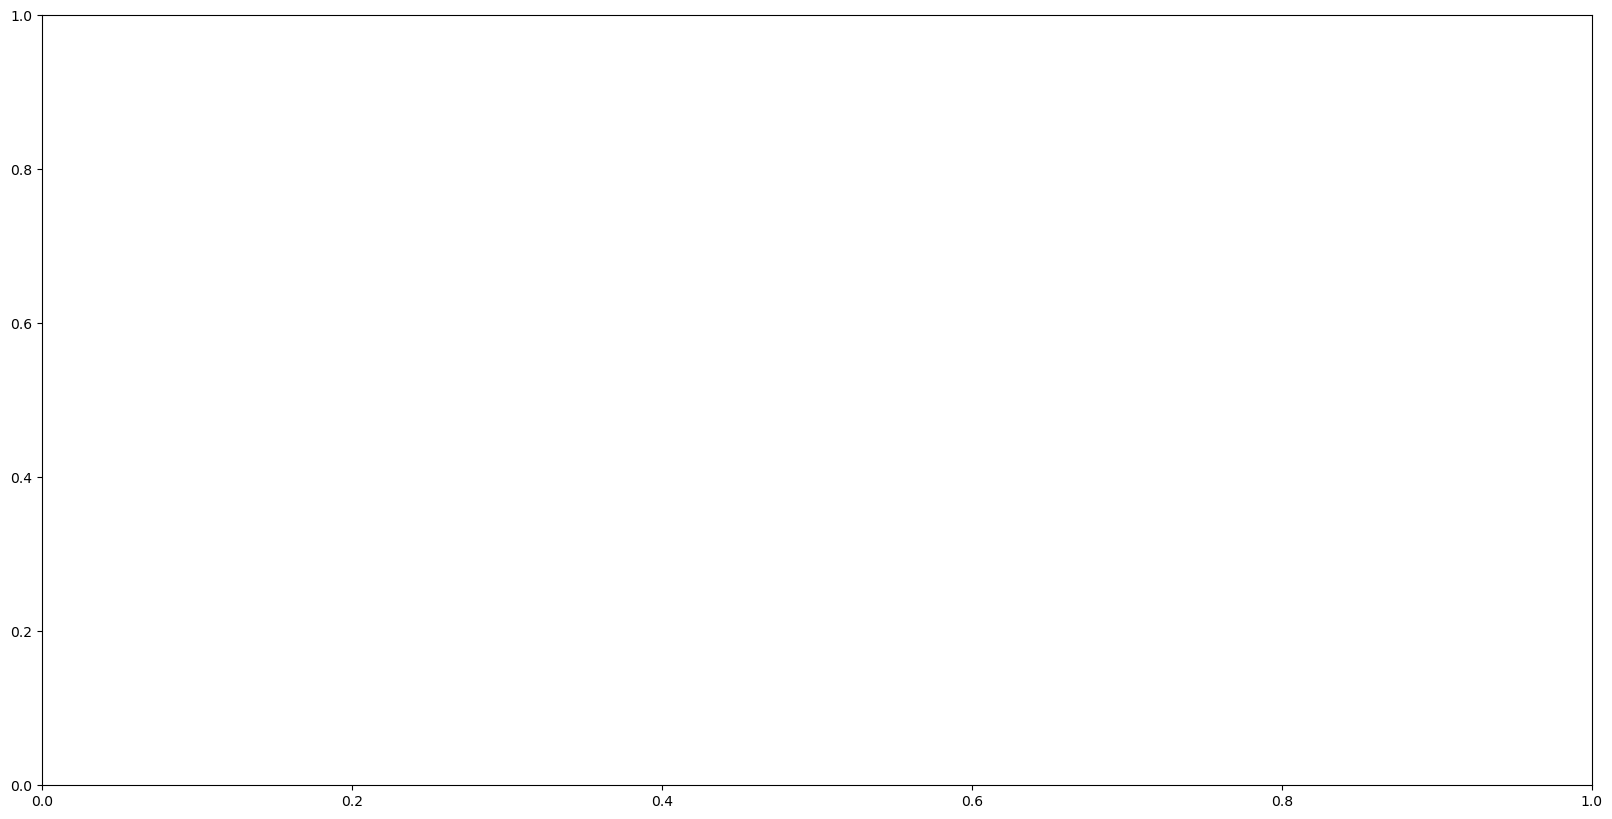

In [258]:
epochs = [i for i in range(1,5+1)]
train_accuracies_5 = copy.deepcopy(train_accuracies)
val_accuracies_5 = copy.deepcopy(val_accuracies)
test_accuracies_5 = copy.deepcopy(test_accuracies) * 5 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_accuracies_5, color="steelblue", label= 'Train')
ax.plot(epochs, val_accuracies_5, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_accuracies_5, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy with 5 Epochs", fontsize=16)
plt.show()

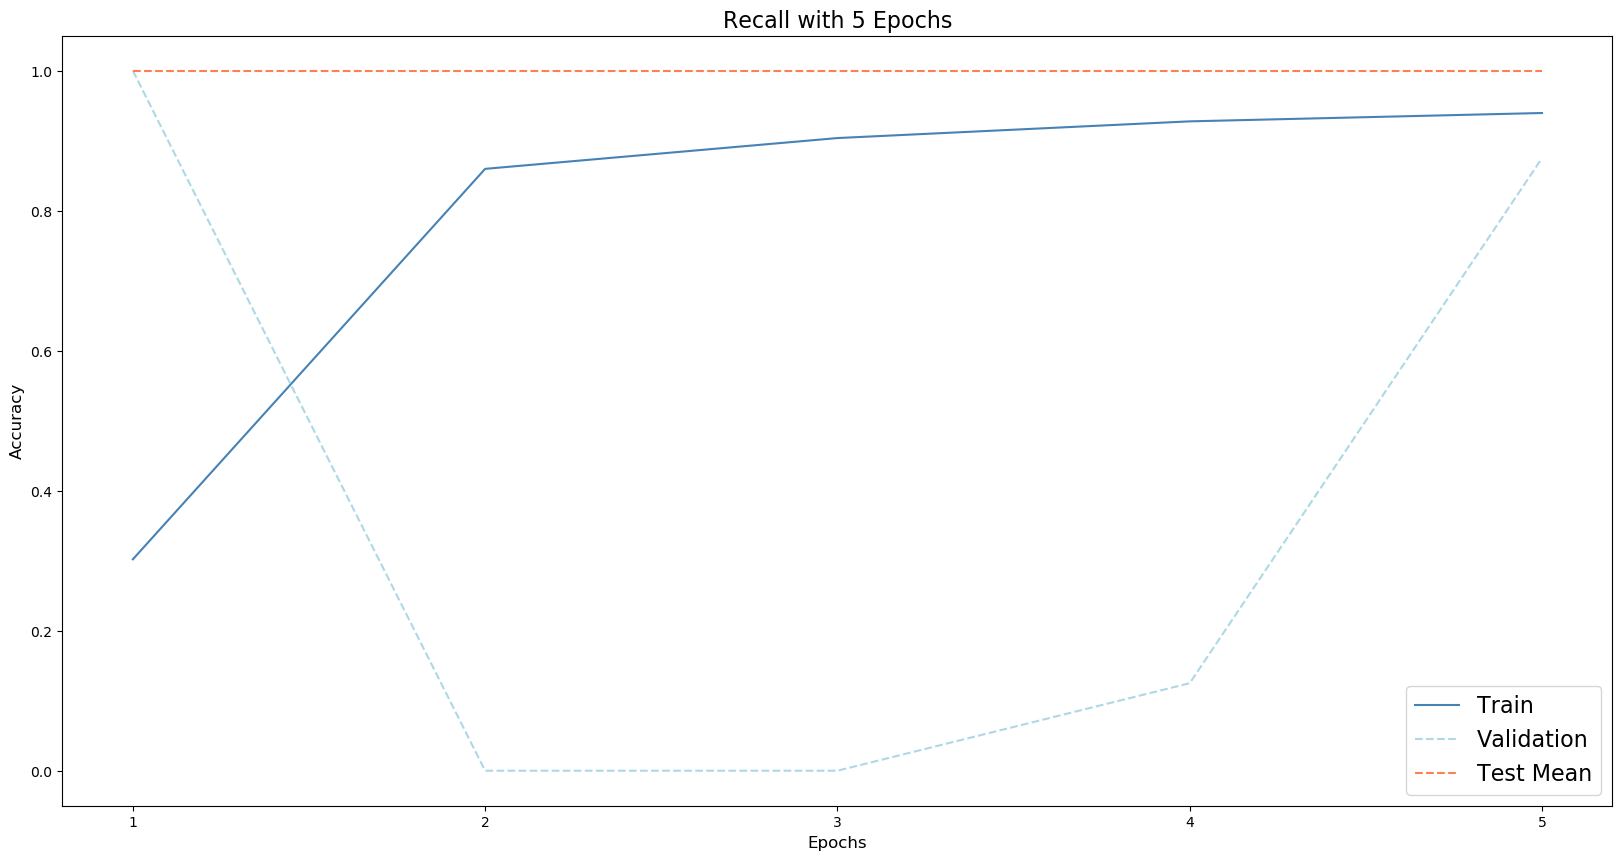

In [ ]:
epochs = [i for i in range(1,5+1)]
train_recalls_5 = copy.deepcopy(train_recalls)
val_recalls_5 = copy.deepcopy(val_recalls)
test_recalls_5 = copy.deepcopy(test_recalls) * 5 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_recalls_5, color="steelblue", label= 'Train')
ax.plot(epochs, val_recalls_5, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_recalls_5, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Recall with 5 Epochs", fontsize=16)
plt.show()

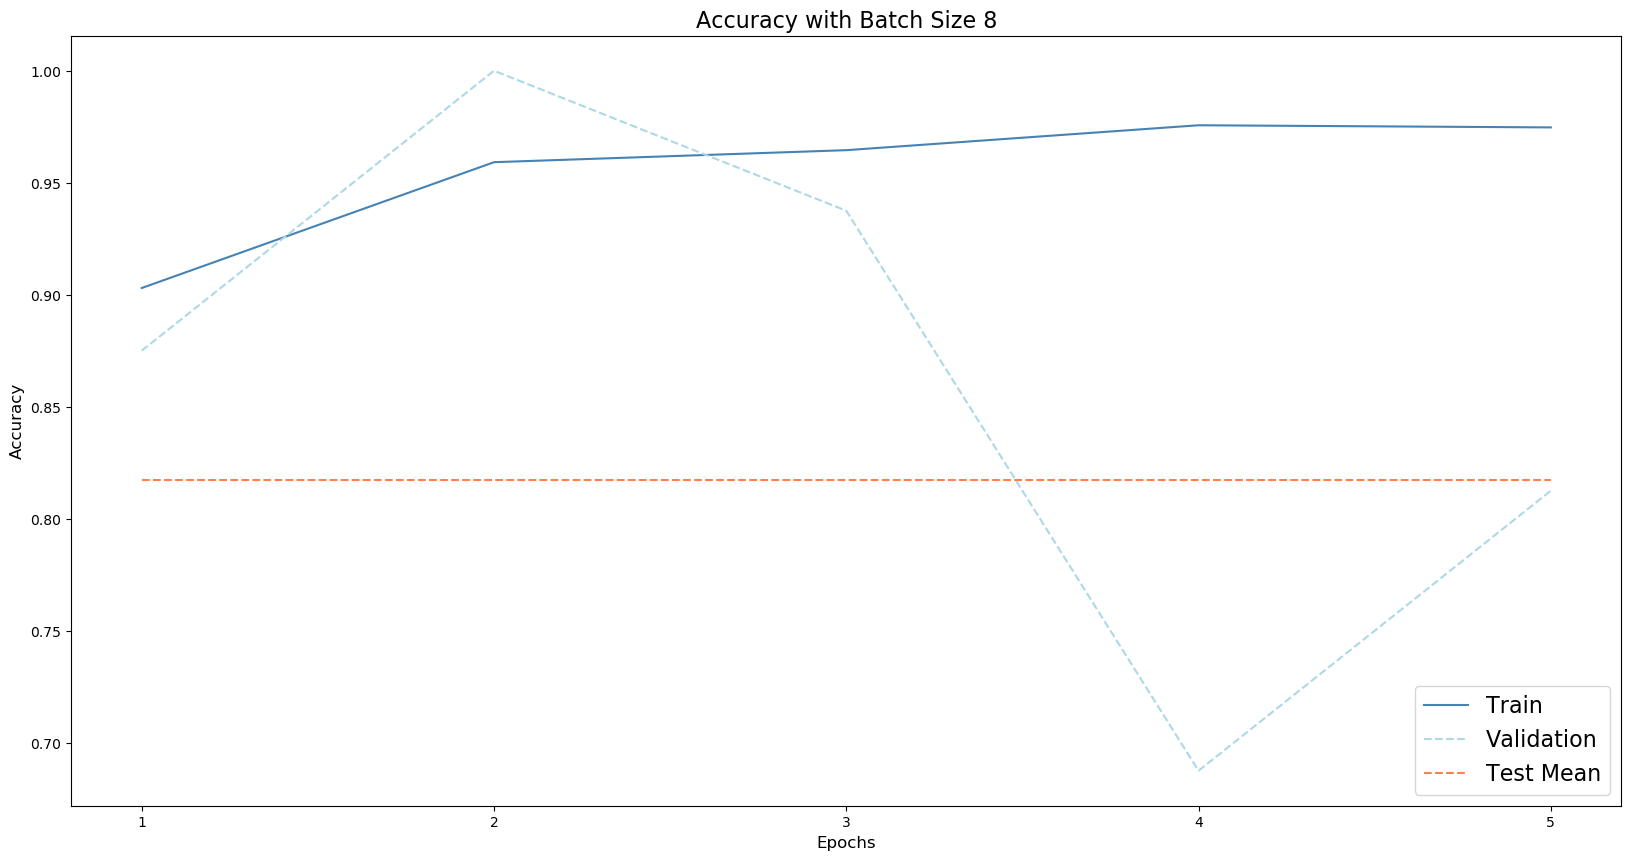

In [ ]:
train_accuracies_batch_8 = [0.9029907975460123, 0.9591641104294478, 0.964532208588957, 0.9756518404907976, 0.9746932515337423]
val_accuracies_batch_8 = [0.875, 1.0, 0.9375, 0.6875, 0.8125]
test_accuracies_batch_8 = [0.8173076923076923] * 5 
epochs = [i for i in range(1,5+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_accuracies_batch_8, color="steelblue", label= 'Train')
ax.plot(epochs, val_accuracies_batch_8, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_accuracies_batch_8, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy with Batch Size 8", fontsize=16)
plt.show()

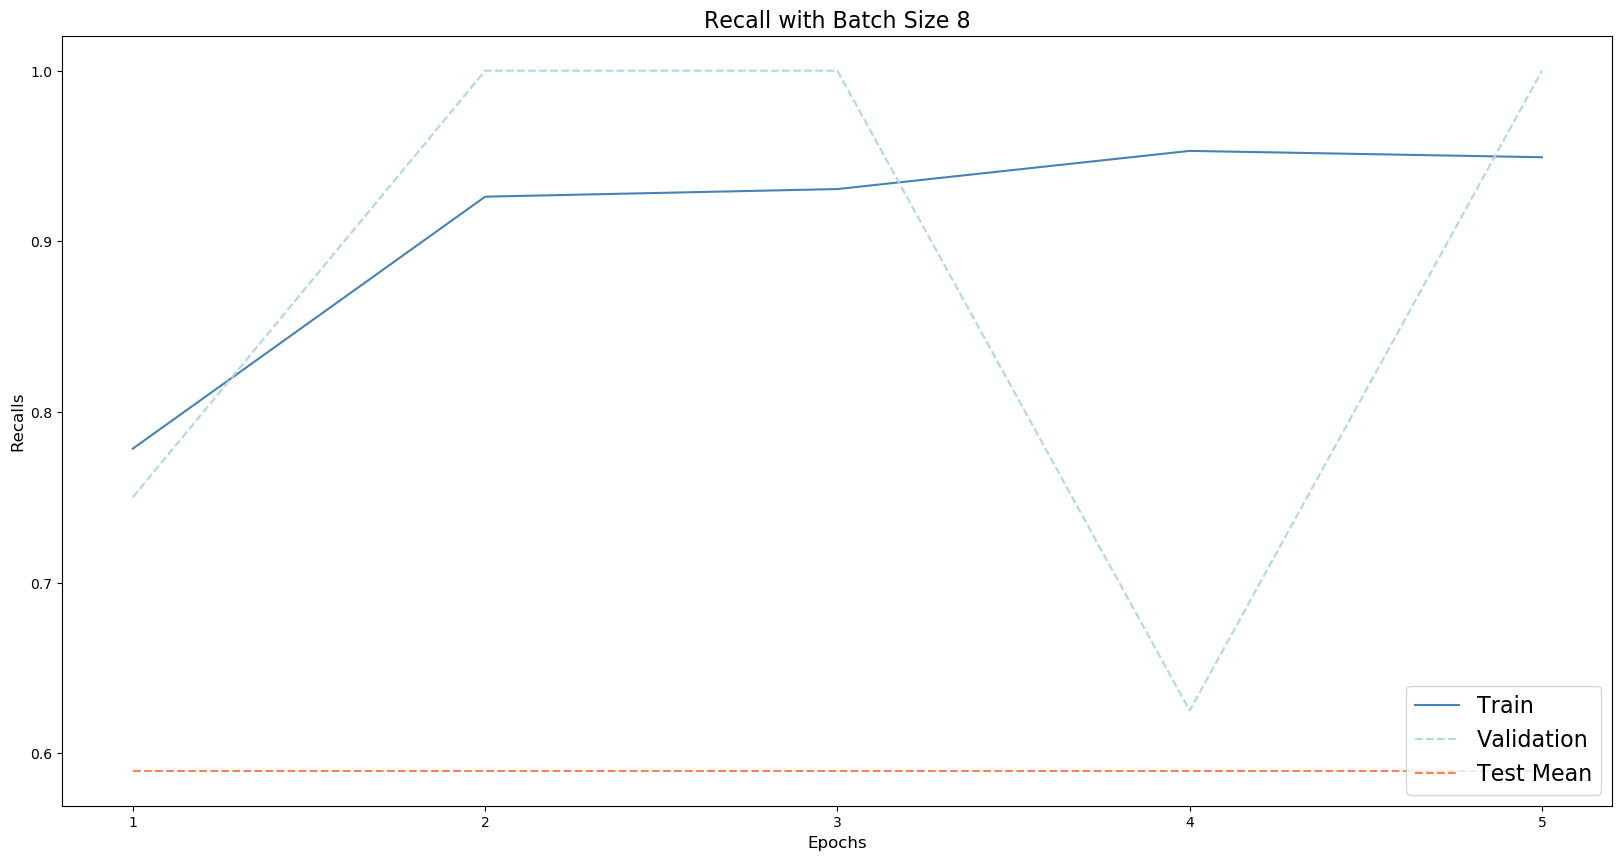

In [ ]:
train_recalls_batch_8 = [0.7785234899328859, 0.9261744966442953, 0.930648769574944, 0.9530201342281879, 0.9492915734526473]
val_recalls_batch_8 = [0.75, 1.0, 1.0, 0.625, 1.0]
test_recalls_batch_8 = [0.5897435897435898] * 5
epochs = [i for i in range(1,5+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_recalls_batch_8, color="steelblue", label= 'Train')
ax.plot(epochs, val_recalls_batch_8, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_recalls_batch_8, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Recalls", fontsize=12)
ax.set_title("Recall with Batch Size 8", fontsize=16)
plt.show()